<a href="https://colab.research.google.com/github/kesanir/ML-AI-TRADING/blob/main/BLACKLITTERMAN_WORKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: curl_cffi
    Found existing installation: curl_cffi 0.14.0
    Uninstalling curl_cffi-0.14.0:
      Successfully uninstalled curl_cffi-0.14.0
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.66
    Uninstalling yfinance-0.2.66:
      Successfully uninstalled yfinance-0.2.66


[*********************100%***********************]  4 of 4 completed


Portfolio Optimization Results:
       Ticker  Weight  Expected Return
Ticker                                
EEM       SPY  1.1723           0.4417
GLD       TLT  0.0156           0.3298
SPY       EEM -1.0608          -0.0527
TLT       GLD  0.8729           0.5336


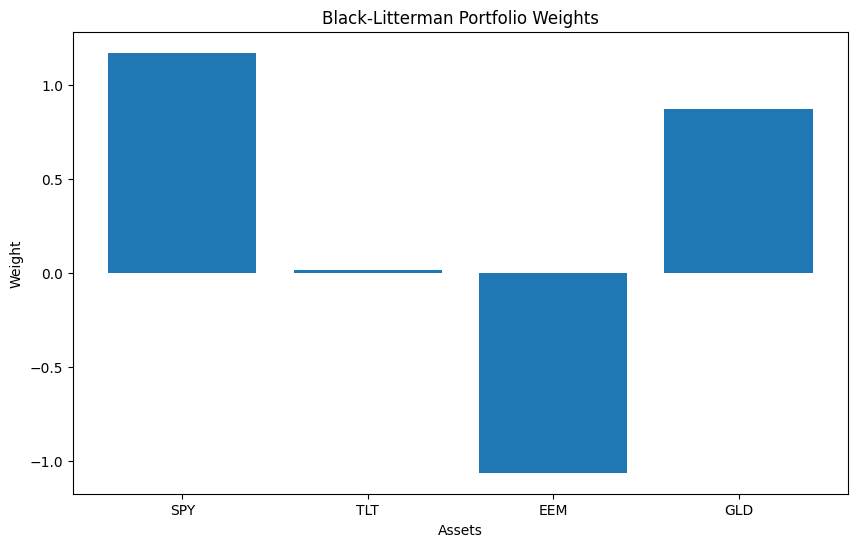

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Function to get historical data
def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

# Black-Litterman model implementation
class BlackLitterman:
    def __init__(self, returns, market_caps, risk_free_rate=0.05):
        self.returns = returns
        self.market_caps = market_caps
        self.risk_free_rate = risk_free_rate
        self.cov_matrix = returns.cov() * 252  # Annualized covariance

    def market_implied_returns(self, risk_aversion=3.0):
        # Calculate market-implied equilibrium returns (Pi)
        weights = self.market_caps / self.market_caps.sum()
        pi = risk_aversion * self.cov_matrix.dot(weights) + self.risk_free_rate
        return pi

    def black_litterman_returns(self, views, view_confidences):
        # Views matrix (Q) and uncertainty matrix (Omega)
        tau = 0.025  # Scaling factor for uncertainty
        P = np.array(views)  # View matrix
        Q = np.array(view_confidences)  # View confidences

        # Calculate Omega (uncertainty in views)
        omega = np.diag([tau * P[i].T.dot(self.cov_matrix).dot(P[i])
                        for i in range(len(Q))])

        # Market implied returns
        pi = self.market_implied_returns()

        # BL combined return vector
        M_inv = np.linalg.inv(tau * self.cov_matrix)
        posterior_returns = pi + tau * self.cov_matrix.dot(P.T).dot(
            np.linalg.inv(P.dot(tau * self.cov_matrix).dot(P.T) + omega)
        ).dot(Q - P.dot(pi))

        return posterior_returns

    def optimize_portfolio(self, bl_returns):
        # Mean-variance optimization
        n_assets = len(self.returns.columns)
        inv_cov = np.linalg.inv(self.cov_matrix)

        # Calculate optimal weights
        ones = np.ones(n_assets)
        numerator = inv_cov.dot(bl_returns - self.risk_free_rate)
        denominator = ones.T.dot(inv_cov).dot(ones)
        weights = numerator / denominator

        return weights / weights.sum()  # Normalize weights

def main():
    # Parameters
    tickers = ['SPY', 'TLT', 'EEM', 'GLD']
    end_date = datetime(2026, 2, 28)
    start_date = end_date - timedelta(days=5*365)  # 5 years of data

    # Get historical data
    data = get_data(tickers, start_date, end_date)
    returns = data.pct_change().dropna()

    # Market capitalization approximations (in billions)
    market_caps = pd.Series({
        'SPY': 400,  # S&P 500 ETF
        'TLT': 50,   # Treasury Bond ETF
        'EEM': 30,   # Emerging Markets ETF
        'GLD': 60    # Gold ETF
    })

    # Initialize Black-Litterman model
    bl_model = BlackLitterman(returns, market_caps)

    # Define views (example)
    # View 1: SPY will outperform TLT by 5%
    # View 2: GLD will return 3%
    views = [
        [1, 0, -1, 0],  # SPY - TLT
        [0, 0, 0, 1]    # GLD
    ]
    view_confidences = [1, 1]

    # Calculate BL returns and optimal weights
    bl_returns = bl_model.black_litterman_returns(views, view_confidences)
    weights = bl_model.optimize_portfolio(bl_returns)

    # Results
    results = pd.DataFrame({
        'Ticker': tickers,
        'Weight': weights,
        'Expected Return': bl_returns
    })

    print("\nPortfolio Optimization Results:")
    print(results.round(4))

    # Plot portfolio weights
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, weights)
    plt.title('Black-Litterman Portfolio Weights')
    plt.xlabel('Assets')
    plt.ylabel('Weight')
    plt.show()

if __name__ == "__main__":
    # Required installations: pip install numpy pandas yfinance matplotlib
    main()

[*********************100%***********************]  4 of 4 completed


Columns: ['SPY', 'TLT', 'EEM', 'GLD']
Shape: (1255, 4)
Returns sample:
                  SPY       TLT       EEM       GLD
Date                                              
2021-03-02 -0.007803  0.000071 -0.009788  0.005448
2021-03-03 -0.013246 -0.010846 -0.002014 -0.011022
2021-03-04 -0.012375 -0.006450 -0.023294 -0.009837
2021-03-05  0.018396  0.001947  0.010892  0.000629
Returns sample:
                  SPY       TLT       EEM       GLD
Date                                              
2026-02-24  0.007269  0.001783  0.015734 -0.013859
2026-02-25  0.008438  0.000111  0.011019 -0.002507
2026-02-26 -0.005554  0.004004 -0.009477  0.008576
2026-02-27 -0.004802  0.006093 -0.002073  0.013131

Portfolio Optimization Results:
    Ticker  Weight  Expected Return
SPY    SPY    0.40           0.0654
TLT    TLT    0.05           0.0249
EEM    EEM    0.40           0.0597
GLD    GLD    0.15           0.0269


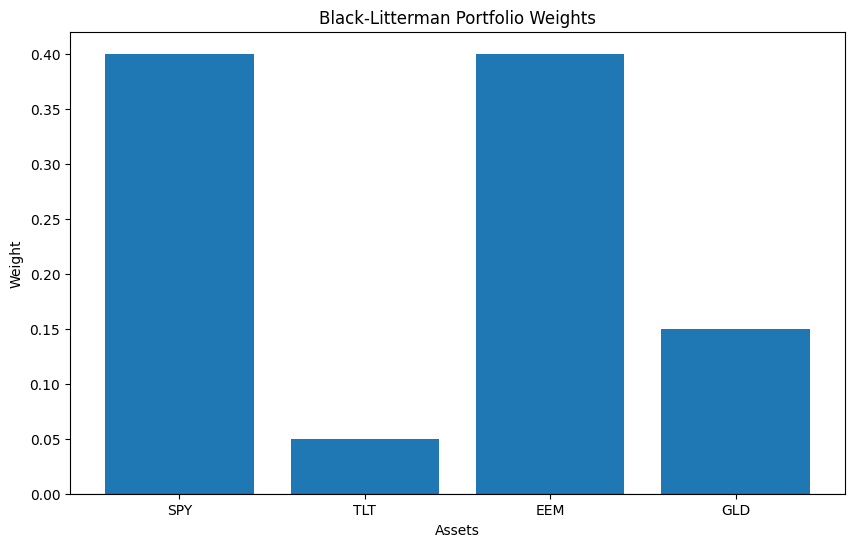

  Ticker  BL Weight  Risk Parity Weight
0    SPY       0.40              0.2358
1    TLT       0.05              0.2964
2    EEM       0.40              0.2041
3    GLD       0.15              0.2637


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)

    # Handle MultiIndex columns from newer yfinance versions
    if isinstance(data.columns, pd.MultiIndex):
        data = data['Close']
    else:
        data = data['Close']

    # Ensure columns are clean strings
    data.columns = [str(col) for col in data.columns]
    return data[tickers]  # enforce consistent ordering


class BlackLitterman:
    def __init__(self, returns, market_caps, risk_free_rate=0.05):
        self.returns = returns
        self.market_caps = market_caps
        self.risk_free_rate = risk_free_rate
        self.cov_matrix = returns.cov() * 252

    def market_implied_returns(self, risk_aversion=3.0):
        weights = self.market_caps / self.market_caps.sum()
        # FIX 1: Remove risk_free_rate — Pi is excess return
        pi = risk_aversion * self.cov_matrix.dot(weights)
        return pi

    def black_litterman_returns(self, views, view_returns, view_confidences):
        tau = 0.025
        P = np.array(views)
        Q = np.array(view_returns)       # FIX 2: Separate Q (returns) ...
        C = np.array(view_confidences)   # ... from confidence scaling

        # Scale Omega by confidence: higher confidence = smaller Omega
        omega = np.diag([
            (tau * P[i].T.dot(self.cov_matrix).dot(P[i])) / C[i]
            for i in range(len(Q))
        ])

        pi = self.market_implied_returns()

        posterior_returns = pi + tau * self.cov_matrix.dot(P.T).dot(
            np.linalg.inv(P.dot(tau * self.cov_matrix).dot(P.T) + omega)
        ).dot(Q - P.dot(pi))

        return posterior_returns

    def optimize_portfolio(self, bl_returns):
        from scipy.optimize import minimize
        n = len(bl_returns)
        inv_cov = np.linalg.inv(self.cov_matrix)

        def neg_sharpe(w):
            ret = w @ bl_returns
            vol = np.sqrt(w @ self.cov_matrix @ w)
            return -(ret - self.risk_free_rate) / vol

        constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
        bounds = [(0.05, 0.40)] * n  # min 5%, max 40% per asset
        w0 = np.ones(n) / n

        result = minimize(neg_sharpe, w0, bounds=bounds, constraints=constraints)
        return result.x
    def risk_parity_weights(self):

        #cov = self.cov_matrix  # already computed in __init__
        n = len(self.cov_matrix)

        def risk_budget_objective(w):
            w = np.array(w)
            portfolio_vol = np.sqrt(w @ self.cov_matrix @ w)
            marginal_risk = self.cov_matrix @ w / portfolio_vol
            risk_contributions = w * marginal_risk
            # Each asset should contribute equally to total risk
            target = portfolio_vol / n
            return np.sum((risk_contributions - target) ** 2)

        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0.01, 1.0)] * n
        w0 = np.ones(n) / n

        result = minimize(risk_budget_objective, w0,
                     bounds=bounds, constraints=constraints,
                     method='SLSQP')
        return result.x

def main():
    tickers = ['SPY', 'TLT', 'EEM', 'GLD']
    end_date = datetime(2026, 2, 28)
    start_date = end_date - timedelta(days=5*365)

    data = get_data(tickers, start_date, end_date)
    returns = data.pct_change().dropna()

    #returns = data.pct_change().dropna()
    print("Columns:", returns.columns.tolist())       # should be ['SPY','TLT','EEM','GLD']
    print("Shape:", returns.shape)                    # should be (~1260, 4)
    print("Returns sample:\n", returns.head(4))
    print("Returns sample:\n", returns.tail(4))
    market_caps = pd.Series({
        'SPY': 200,
        'TLT': 80,
        'EEM': 60,
        'GLD': 100
    })

    bl_model = BlackLitterman(returns, market_caps)

    views = [
    [1, 0,  0,  0],   # SPY absolute return
    [0, 1,  0,  0],   # TLT absolute return
    [0, 0,  1,  0],   # EEM absolute return
    [0, 0,  0,  1],   # GLD absolute return
    ]

    view_returns = [
    0.09,   # SPY: ~9% (median consensus)
    0.04,   # TLT: ~4% (mild tailwind from 50bps cuts)
    0.07,   # EEM: ~7% (cautiously positive)
    0.01,   # GLD: ~15% (JPM $5k target, strong consensus bull)
    ]

    view_confidences = [
    0.5,    # SPY: reasonably high confidence (many firms aligned)
    0.3,    # TLT: low confidence (rate path uncertain, new Fed chair risk)
    0.4,    # EEM: moderate-low (heavily US-dependent)
    0.5,    # GLD: high confidence (4th year consensus bull)
    ]

    bl_returns = bl_model.black_litterman_returns(views, view_returns, view_confidences)
    weights = bl_model.optimize_portfolio(bl_returns)

    results = pd.DataFrame({
        'Ticker': tickers,
        'Weight': weights,
        'Expected Return': bl_returns
    })

    print("\nPortfolio Optimization Results:")
    print(results.round(4))

    plt.figure(figsize=(10, 6))
    plt.bar(tickers, weights)
    plt.title('Black-Litterman Portfolio Weights')
    plt.xlabel('Assets')
    plt.ylabel('Weight')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.show()
    bl_weights = bl_model.optimize_portfolio(bl_returns)

    # Risk parity weights (no views needed)
    rp_weights = bl_model.risk_parity_weights()

    # Compare
    comparison = pd.DataFrame({
    'Ticker': tickers,
    'BL Weight': bl_weights.round(4),
    'Risk Parity Weight': rp_weights.round(4)
    })
    print(comparison)
if __name__ == "__main__":
    main()